# Semantic Segmentation with Captum - GradientSHAP

This Notebook is intended to run a GUI for the interpretability of a binary segmentation model.

Any segmentation model can be loaded with some test dataset and the user can interact with the GUI to see the results.

In this notebook, we applied explainability to a UNET model that was firstly trained on 7 variables from the 0.25 degrees [SeasFire Datacube](https://zenodo.org/record/7108392) and then loaded into the GUI.

Since loading the input data from the datacube into memory is a time consuming process, a small toy dataset is included [in this repository](https://github.com/PiSchool/noa-xai-for-wildfire-forecasting/tree/main/data/raw) and will be loaded here.


🔥 
**This notebook can be run either on colab or locally ona  classic notebook. Just uncomment some sections if working in colab**

## 1. Imports all necessary packages

In [1]:
%%capture
# 🔥 If working on colab

#  1. uncomment the following:
# %pip install ipywidgets ipyleaflet ipympl -q
# %pip install captum zarr geopandas shapely -q
# %pip install rioxarray -q
# from google.colab import drive
# drive.mount('/content/drive')
# !cp "../utils/plots.py" .
# !cp "../utils/model.py" .
# !cp "../utils/dataloader.py" .
# import utils

#  2. comment the following:
%cd ../..
import utils

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import xarray as xr
from pathlib import Path
import zarr
import pandas as pd
from scipy import stats
from tqdm.notebook import tqdm as ntqdm
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
from captum.attr import *
import rioxarray, rasterio
from rasterio.warp import reproject
from rasterio.enums import Resampling
from io import BytesIO

# interactive visualization
import ipyleaflet, ipywidgets, matplotlib.pyplot as plt
import PIL
from base64 import b64encode
from ipyleaflet import Map, ImageOverlay, basemap_to_tiles, basemaps
import warnings
# Default device
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
train_on_gpu = torch.cuda.is_available()
print(f"GPU available? {train_on_gpu}")
SEED = 172
MODEL_NO = 0  # in K-fold
N_FOLDS = 10  # in K-fold
utils.seed_everything(SEED)

GPU available? False


## 2. Load dataset
Here we load the test dataset in chuncks of 90x90 pixels. 

Since we are loading all the data into memory  (in order to be more computationally efficient later), we are careful on just loading the chunks that contains at least 1 burned pixel, to save RAM space (it will require around 7 Gb for the entide datacube, but just a few MB for the examples provided in this repository). 


It is possible to modify this behaviour if less space is available just calling a smaller time slice in "utils.create_datasets_model" or doing a lazy loading (necessary to modify the "utils.dataloader.FireDataset")

In [4]:
### INPUTS
### if using colab:
# 1. uncomment this lines:
# ds = xr.open_zarr('/content/drive/MyDrive/seasfire.zarr')
# file_mean_std = '/content/drive/MyDrive/challenge - NOA - XAI for Wildfire Forecasting/Notebooks/develop_Giovanni/table_mean_std.csv'
# GFED_file = "/content/drive/MyDrive/challenge - NOA - XAI for Wildfire Forecasting/Data/Biomes_and_GFED/GFED_basis_regions.nc"
# biomes_file = "/content/drive/MyDrive/challenge - NOA - XAI for Wildfire Forecasting/Data/Biomes_and_GFED/biomes.nc"
# file_global_delta1 = "/content/drive/MyDrive/challenge - NOA - XAI for Wildfire Forecasting/Models checkpoints/NEW_unet_ml_7vars_log_tp_popdens_delta1ts_GLOBAL_2001_2016.pt"
# 2. comment this lines:

ds1 = xr.open_dataset("./data/raw/tiny_seasfire_europe_2019_2020_7vars.nc")  # the datacube must be stired in "data folder"
ds2 = xr.open_dataset("./data/raw/tiny_seasfire_africa_2019_2020_7vars.nc")  # the datacube must be stired in "data folder"

ds2 = ds2.assign(pop_dens_LOG=lambda x: np.log(1 + x["pop_dens"]))
ds2 = ds2.assign(tp_LOG=lambda x: np.log(1 + x["tp"]))

file_mean_std = "./data/processed/table_mean_std_7vars_binarysegmentation.csv"
GFED_file = "./data/Biomes_and_GFED/GFED_basis_regions.nc"
biomes_file = "./data/Biomes_and_GFED/biomes.nc"
file_global_delta1 = (
    "./models/NEW_unet_ml_7vars_log_tp_popdens_delta1ts_GLOBAL_2001_2016.pt"
)

## PROCESSING
ds = xr.merge([ds1, ds2]).sortby(["latitude"], ascending=False)
mask_water = xr.where(ds.lsm >= 0.9, 1, 0).astype(bool)

variables_selected = [
    "rel_hum",
    "ndvi",
    "pop_dens_LOG",
    "lsm",
    "tp_LOG",
    "gwis_ba",
    "sst",
    "lst_day",
]

if not Path(file_mean_std).exists():
    ### SAVE IN A TABLE GLOBAL MEAN AND STD for EACH VARIABLE
    vmean = ds.mean()[variables_selected].load().to_pandas()
    vmean.name = "mean"
    vstd = ds.std()[variables_selected].load().to_pandas()
    vstd.name = "std"
    table_mean_std = pd.concat([vmean, vstd], axis=1)
    table_mean_std.to_csv(file_mean_std)
else:
    table_mean_std = pd.read_csv(file_mean_std, index_col=0, header=0)

ds = ds.chunk(dict(time=len(ds.time), latitude=90, longitude=90))

*__, test_dataset = utils.create_datasets_model(
    ds[variables_selected],
    slice_train=None,
    slice_valid=None,
    slice_test=slice("20190101", "20201231"),
    table_mean_std=table_mean_std,
    target="gwis_ba",
    delta_time=1,
    inland_map=mask_water,
)
test_dataset.dx = test_dataset.dx.astype(np.float32)

num_workers = 0
bs = 4
test_loader = DataLoader(
    test_dataset, batch_size=bs, shuffle=False, num_workers=num_workers
)

check on chuncks with fire:   0%|          | 0/4 [00:00<?, ?it/s]

out of 736 chuncks, 680 have at least 1 fire pixel (92.39%)


loading in memory:   0%|          | 0/8 [00:00<?, ?it/s]

### 2.1 Read Different Biomes

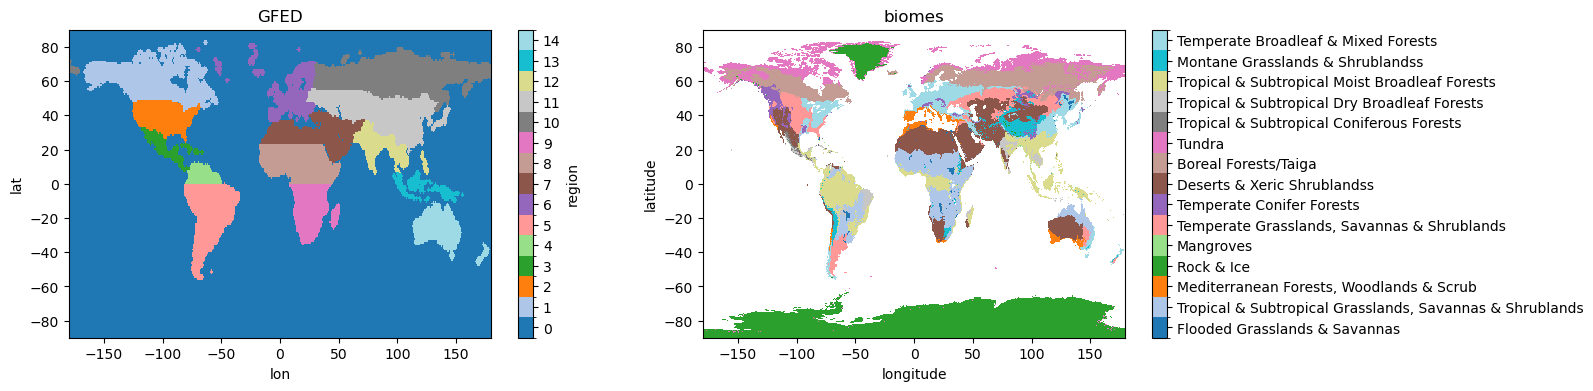

In [5]:
# read biomes (0.25 deg)
dd_bio = xr.open_dataset(biomes_file)
# read gfed (1 deg) and interpolate like biomes (0.25 deg)
dd_gfed = xr.open_dataset(GFED_file).interp_like(dd_bio, method="nearest")
dict_biomes = dict(
    [
        (1, "Flooded Grasslands & Savannas"),
        (2, "Tropical & Subtropical Grasslands, Savannas & Shrublands"),
        (3, "Mediterranean Forests, Woodlands & Scrub"),
        (4, "Rock & Ice"),
        (5, "Mangroves"),
        (6, "Temperate Grasslands, Savannas & Shrublands"),
        (7, "Temperate Conifer Forests"),
        (8, "Deserts & Xeric Shrublandss"),
        (9, "Boreal Forests/Taiga"),
        (10, "Tundra"),
        (11, "Tropical & Subtropical Coniferous Forests"),
        (12, "Tropical & Subtropical Dry Broadleaf Forests"),
        (13, "Tropical & Subtropical Moist Broadleaf Forests"),
        (14, "Montane Grasslands & Shrublandss"),
        (15, "Temperate Broadleaf & Mixed Forests"),
    ]
)

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
dd_gfed.region.plot(
    ax=axs[0],
    cmap="tab20",
    levels=np.concatenate([[-0.5], np.unique(dd_gfed.region) + 0.5]),
    cbar_kwargs={"ticks": list(range(15)), "spacing": "proportional"},
)

im = dd_bio.biomes.plot.imshow(
    ax=axs[1],
    cmap="tab20",
    levels=np.array([0] + list(dict_biomes.keys())) + 0.5,
    add_colorbar=False,
)
cb = plt.colorbar(im, ticks=list(dict_biomes.keys()), spacing="proportional")
cb.set_ticklabels(list(dict_biomes.values()))
axs[0].set(title="GFED")
ttl = axs[1].set(title="biomes")

In [6]:
%%capture --no-display
# The object "test_dataset" contains now a dataframe with the list of accepted chucks ("test_dataset.accepted_slices") that indicates the position in time and lat/lon of each selected chunks. 
# Here we add a few columns to the dataframe to have an indication on what is the most prevalent biome that is burnt per chunck.

def modefun(x, biomes):
    xc, yc = (x > 0).nonzero()
    u = biomes[xc, yc]
    u = u[~np.isnan(u)]
    return stats.mode(u, keepdims=True)

dd_bio = dd_bio.sel(latitude = ds.latitude, longitude = ds.longitude)

new_acc_slices = test_dataset.accepted_slices.copy()
for kk, gp in new_acc_slices.groupby("chunk_nbr"):
    biomes = dd_bio.biomes.isel(gp[["latitude", "longitude"]].iloc[0].to_dict()).values
    y_burned = (
        test_dataset.dy.isel(gp[["latitude", "longitude"]].iloc[0].to_dict())
        .isel(time=gp.time.values)
        .values
    )
    median_vals = [float(modefun(x, biomes)[0]) for x in y_burned]
    n_pixels = [float(modefun(x, biomes)[1]) for x in y_burned]

    new_acc_slices.loc[gp.index, "mode biomes burned"] = median_vals
    new_acc_slices.loc[gp.index, "pixel in mode biomes burned"] = n_pixels
new_acc_slices = new_acc_slices.sort_values(
    "pixel in mode biomes burned", ascending=False
).dropna(subset=["mode biomes burned"])
new_acc_slices["date"] = new_acc_slices.time.apply(lambda x: test_dataset.ds.time.dt.date[x].values)

# new_acc_slices.head(10)

## 3. Load Model

In [7]:
model = utils.UNet(n_channels=len(test_dataset.features), n_classes=1).float()
gpu_available = torch.cuda.is_available()
if gpu_available:
    model.cuda()
model.load_state_dict(torch.load(file_global_delta1, map_location=torch.device("cpu")))
evmode = model.eval()

## 4. xAI with Captum - visualization

In [8]:
dict_functions_shap = {
    "Saliency":Saliency(model),
    "DeepLift":DeepLift(model, multiply_by_inputs=True),
    # "DeepLiftShap":DeepLiftShap(model, multiply_by_inputs=True),
    "GradientShap":GradientShap(model, multiply_by_inputs=True),
    "Integrated Gradients (a bit SLOW)":IntegratedGradients(model, multiply_by_inputs=True),
    "Input X Gradient":InputXGradient(model),
    "Guided Backprop":GuidedBackprop(model),
    # "Guided GradCAM":GuidedGradCam(model),
    "Deconvolution":Deconvolution(model),
    # "Feature Ablation - NOT working":FeatureAblation(model),
    # "Occlusion- NOT working":Occlusion(model),
    # "Feature Permutation - NOT working":FeaturePermutation,
    # "Shapley Value Sampling - NOT working":ShapleyValueSampling(model),
    "Lime (SLOW)":Lime(model),
    "KernelShap (SLOW)":KernelShap(model),
    # "LRP - NOT working": LRP(model)
                      }

def cluster_in_Npixels_grid(xco,yco, Npixels=10):
    """
    Function used not to show and compute too many fires in the same place.
    The function clusters coordinates in N-pixels grid (default is 10 pixel grid) in the simplest way possible. 
    It takes the first coordinate of each group and returns the x and y coordinates of the new grid.
    """
    df_to_group = pd.DataFrame([xco, yco, [f"{xc//Npixels}_{yc//Npixels}" for xc,yc in zip(xco,yco)]], index=["xco", "yco", "group"]).T
    df_grouped  = df_to_group.groupby("group").first()
    return df_grouped.xco.values, df_grouped.yco.values 


def select_image(n_picture, dataset, ai_model):
    example = dataset[n_picture][0].unsqueeze(0)  # .cpu().detach()
    target = dataset[n_picture][1]
    original_input_values = dataset.dx[n_picture]
    no_burn = example.mean((2, 3)).unsqueeze(2).unsqueeze(3).expand(example.shape)
    pred = ai_model(example.to(device)).cpu().detach()
    # baseline_pred = ai_model(no_burn.to(device)).cpu().detach()
    array_coords = dataset.dy.isel(
        dataset.accepted_slices[[*dataset.dy.dims]].iloc[n_picture].to_dict()
    )
    lb = dd_bio.biomes.isel(
        dataset.accepted_slices[[*dd_bio.biomes.dims]].iloc[n_picture].to_dict()
    )
    
    # burned_biomes_classes = np.unique(
    #     local_biome[((pred[0].numpy() > 0.4) & (~np.isnan(local_biome)))]
    # )
    # mshap = GradientShap(ai_model, multiply_by_inputs=True)
    # dict_functions_shap = {"GradientShap":mshap,"mshap":mshap, "mshap":mshap}

    example = example.to(device)
    no_burn = no_burn.to(device)
    filter_positive = (pred[0].numpy() > 0.4) & (target == 1)
    filter_false_positives = (pred[0].numpy() > 0.4) & (target == 0)
    filter_false_negatives = (pred[0].numpy() < 0.4) & (target == 1)
    yco_pos, xco_pos = (filter_positive).nonzero()
    xcoc, ycoc = cluster_in_Npixels_grid(xco_pos,yco_pos, Npixels=10)
    # xcoc, ycoc = xco_pos, yco_pos

    yco_fpos, xco_fpos = (filter_false_positives).nonzero()
    xcoc_fpos, ycoc_fpos = cluster_in_Npixels_grid(xco_fpos,yco_fpos, Npixels=10)
    # xcoc_fpos, ycoc_fpos = xco_fpos, yco_fpos
    
    yco_fneg, xco_fneg = (filter_false_negatives).nonzero()
    xcoc_fneg, ycoc_fneg = cluster_in_Npixels_grid(xco_fneg,yco_fneg, Npixels=10)
    # xcoc_fneg, ycoc_fneg = xco_fneg, yco_fneg
    
    latitudes = array_coords.latitude
    longitudes = array_coords.longitude

    
    return {"example":example, "target": target, "no_burn":no_burn, 
            "original_input_values":original_input_values, "pred": pred, 
            "latitudes":latitudes, "longitudes":longitudes, 
            "lb":lb, "xcoc":xcoc, "ycoc":ycoc, "xcoc_fpos":xcoc_fpos, "ycoc_fpos":ycoc_fpos, "xcoc_fneg":xcoc_fneg, "ycoc_fneg":ycoc_fneg}

def create_dictionary_inputsVSattributions(coord_x, coord_y, dd=10, captum_function = None, example=None, no_burn = None, original_input_values=None, latitudes = None, longitudes = None):
    xnew = coord_x
    ynew = coord_y
    lat_burn = latitudes.isel(latitude=ynew).latitude.values
    lon_burn = longitudes.isel(longitude=xnew).longitude.values
    key = f"{lon_burn}_{lat_burn}"
    minx = max(0, xnew - dd)
    miny = max(0, ynew - dd)
    maxx = min(89, xnew + dd)
    maxy = min(89, ynew + dd)
    
    if no_burn is None:
        attribution = captum_function.attribute(example, target=(xnew, ynew)).cpu()
    else:
        attribution = captum_function.attribute(example, no_burn, target=(xnew, ynew)).cpu()
    
    
    att_tot = attribution[:, :, slice(minx, maxx), slice(miny, maxy)].reshape(1, example.shape[1], -1)
    val_tot = original_input_values[:, slice(miny, maxy), slice(minx, maxx)].reshape(
        example.shape[1], -1
    )
    return {key: np.concatenate([val_tot[np.newaxis, ...], att_tot.detach().numpy()], axis=0)}


dict_tot = {}
dd=20
n_picture = 302#79#302#74  # 1835#3445
all_outputs_dict = select_image(n_picture, dataset = test_dataset, ai_model= model)
example, target, no_burn, original_input_values, latitudes, longitudes, lb = all_outputs_dict["example"], all_outputs_dict["target"], all_outputs_dict["no_burn"], all_outputs_dict["original_input_values"], all_outputs_dict["latitudes"], all_outputs_dict["longitudes"], all_outputs_dict["lb"]
xcoc, ycoc = all_outputs_dict["xcoc"], all_outputs_dict["ycoc"]
xcoc_fpos, ycoc_fpos = all_outputs_dict["xcoc_fpos"], all_outputs_dict["ycoc_fpos"]
xcoc_fneg, ycoc_fneg = all_outputs_dict["xcoc_fneg"], all_outputs_dict["ycoc_fneg"]
local_biome = lb.values
list_accepted = ["longitudes", "latitudes", "original_input_values", "example", "no_burn"]
latitudes, longitudes = all_outputs_dict["latitudes"], all_outputs_dict["longitudes"]
additional_inputs_online_attributions = {k: all_outputs_dict[k] for k in list_accepted}


In [9]:
### SET PARAMETER - index of the patch in "test_dataset.accepted_slices"
### Careful: it will create a map for each burned pixel, so it takes a long time when chosing a patch with many burned pixels

def select_image(n_picture, dataset, ai_model):
    example = dataset[n_picture][0].unsqueeze(0)  # .cpu().detach()
    target = dataset[n_picture][1]
    original_input_values = dataset.dx[n_picture]
    no_burn = example.mean((2, 3)).unsqueeze(2).unsqueeze(3).expand(example.shape)
    pred = ai_model(example.to(device)).cpu().detach()
    # baseline_pred = ai_model(no_burn.to(device)).cpu().detach()
    array_coords = dataset.dy.isel(
        dataset.accepted_slices[[*dataset.dy.dims]].iloc[n_picture].to_dict()
    )
    lb = dd_bio.biomes.isel(
        dataset.accepted_slices[[*dd_bio.biomes.dims]].iloc[n_picture].to_dict()
    )
    
    # burned_biomes_classes = np.unique(
    #     local_biome[((pred[0].numpy() > 0.4) & (~np.isnan(local_biome)))]
    # )
    # mshap = GradientShap(ai_model, multiply_by_inputs=True)
    # dict_functions_shap = {"GradientShap":mshap,"mshap":mshap, "mshap":mshap}

    example = example.to(device)
    no_burn = no_burn.to(device)
    filter_positive = (pred[0].numpy() > 0.4) & (target == 1)
    filter_false_positives = (pred[0].numpy() > 0.4) & (target == 0)
    filter_false_negatives = (pred[0].numpy() < 0.4) & (target == 1)
    yco_pos, xco_pos = (filter_positive).nonzero()
    xcoc, ycoc = cluster_in_Npixels_grid(xco_pos,yco_pos, Npixels=10)
    # xcoc, ycoc = xco_pos, yco_pos

    yco_fpos, xco_fpos = (filter_false_positives).nonzero()
    xcoc_fpos, ycoc_fpos = cluster_in_Npixels_grid(xco_fpos,yco_fpos, Npixels=10)
    # xcoc_fpos, ycoc_fpos = xco_fpos, yco_fpos
    
    yco_fneg, xco_fneg = (filter_false_negatives).nonzero()
    xcoc_fneg, ycoc_fneg = cluster_in_Npixels_grid(xco_fneg,yco_fneg, Npixels=10)
    # xcoc_fneg, ycoc_fneg = xco_fneg, yco_fneg
    
    latitudes = array_coords.latitude
    longitudes = array_coords.longitude

    
    return {"example":example, "target": target, "no_burn":no_burn, 
            "original_input_values":original_input_values, "pred": pred, 
            "latitudes":latitudes, "longitudes":longitudes, 
            "lb":lb, "xcoc":xcoc, "ycoc":ycoc, "xcoc_fpos":xcoc_fpos, "ycoc_fpos":ycoc_fpos, "xcoc_fneg":xcoc_fneg, "ycoc_fneg":ycoc_fneg}

def create_dictionary_inputsVSattributions(coord_x, coord_y, dd=10, captum_function = None, example=None, no_burn = None, original_input_values=None, latitudes = None, longitudes = None):
    xnew = coord_x
    ynew = coord_y
    lat_burn = latitudes.isel(latitude=ynew).latitude.values
    lon_burn = longitudes.isel(longitude=xnew).longitude.values
    key = f"{lon_burn}_{lat_burn}"
    minx = max(0, xnew - dd)
    miny = max(0, ynew - dd)
    maxx = min(89, xnew + dd)
    maxy = min(89, ynew + dd)
    
    if no_burn is None:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            attribution = captum_function.attribute(example, target=(xnew, ynew)).cpu()
    else:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            attribution = captum_function.attribute(example, no_burn, target=(xnew, ynew)).cpu()
    
    
    att_tot = attribution[:, :, slice(minx, maxx), slice(miny, maxy)].reshape(1, example.shape[1], -1)
    val_tot = original_input_values[:, slice(miny, maxy), slice(minx, maxx)].reshape(
        example.shape[1], -1
    )
    return {key: np.concatenate([val_tot[np.newaxis, ...], att_tot.detach().numpy()], axis=0)}


dict_tot = {}
dd=20
n_picture = 302#79#302#74  # 1835#3445
all_outputs_dict = select_image(n_picture, dataset = test_dataset, ai_model= model)
example, target, no_burn, original_input_values, latitudes, longitudes, lb = all_outputs_dict["example"], all_outputs_dict["target"], all_outputs_dict["no_burn"], all_outputs_dict["original_input_values"], all_outputs_dict["latitudes"], all_outputs_dict["longitudes"], all_outputs_dict["lb"]
xcoc, ycoc = all_outputs_dict["xcoc"], all_outputs_dict["ycoc"]
xcoc_fpos, ycoc_fpos = all_outputs_dict["xcoc_fpos"], all_outputs_dict["ycoc_fpos"]
xcoc_fneg, ycoc_fneg = all_outputs_dict["xcoc_fneg"], all_outputs_dict["ycoc_fneg"]
local_biome = lb.values
list_accepted = ["longitudes", "latitudes", "original_input_values", "example", "no_burn"]
latitudes, longitudes = all_outputs_dict["latitudes"], all_outputs_dict["longitudes"]
additional_inputs_online_attributions = {k: all_outputs_dict[k] for k in list_accepted}


In [10]:
%matplotlib widget

In [11]:
def from_xarray_to_ImageOverlay(
    da, colormap=plt.cm.tab20, no_data=np.nan, repl_value=16
):
    """Convert a xarray DataArray to a folium ImageOverlay"""
    w, s, e, n = da.rio.bounds()
    acc = np.where(
        np.isnan(da.values) | (da.values == no_data), repl_value, da.values
    ).astype(np.uint8)
    with rasterio.Env():
        src_transform = rasterio.transform.from_bounds(w, s, e, n, *acc.shape)
        src_crs = {"init": "EPSG:4326"}
        dst_crs = {"init": "EPSG:3857"}

        dst_transform, width, height = rasterio.warp.calculate_default_transform(
            src_crs, dst_crs, *acc.shape, *da.rio.bounds()
        )
        acc_web = np.empty((height, width))
        reproject(
            acc,
            acc_web,
            src_transform=src_transform,
            src_crs=src_crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest,
        )
    f = BytesIO()
    acc_im = PIL.Image.fromarray(np.uint8(colormap((acc_web) / repl_value) * 255))
    acc_im.save(f, "png")
    data = b64encode(f.getvalue())
    data = data.decode("ascii")
    imgurl = "data:image/png;base64," + data
    bounds = [(s, w), (n, e)]
    io = ImageOverlay(url=imgurl, bounds=bounds)
    return io, acc_web

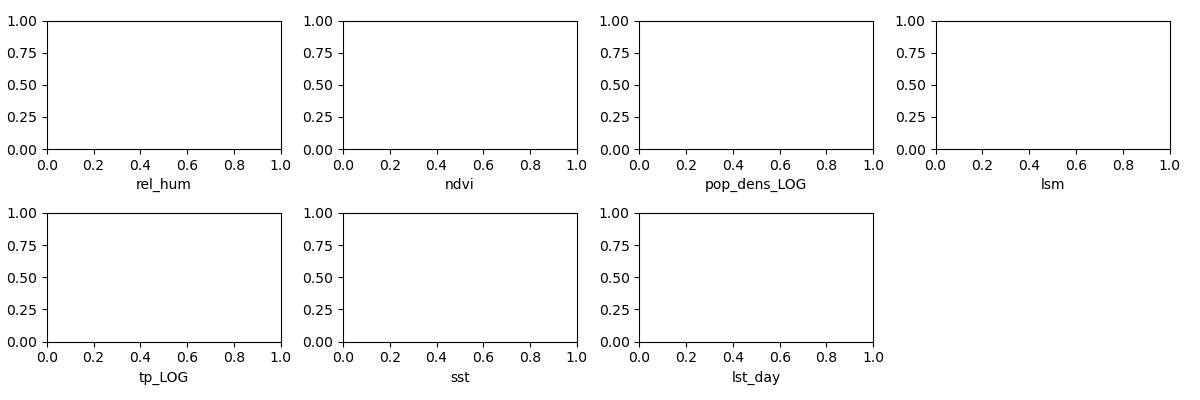

In [13]:
%%capture --no-display

def plot_map_and_scatter(
    data_dict: dict = None, variable_names: list = test_dataset.features, online_attributions = True
):
    global latitudes, longitudes
    global additional_inputs_online_attributions
    # global dd
    """
    Function to create 2 interactive subplots with ipyleaflet and ipywidgets.
    The input of the function is a dictionary with as keys the lat and lon of the points (formatted as a string like f'{lat}_{lon}') and as values a 2d numpy array with shape (N, 2) being N a variable quantity.
    In the first plot there is a map with markers extracted from the dictionary keys. When clicked on a marker, the second plot is updated with the corresponding data.
    The second plot is a scatter plot with the data from the dictionary values. The x axis is the first column of the array and the y axis is the second column of the array.
    if online_attributions is True, the attributions are computed online, otherwise they are taken from the dictionary values.
    """
    if data_dict is None:
        data_dict = {}

    # Build the widgets and the map
    ## create row 0 - two dropdowns to chose chunk and date
    drop_cn     = ipywidgets.Dropdown(options=new_acc_slices.chunk_nbr.drop_duplicates().sort_values().values, index=0, description="# chunk")
    drop_date   = ipywidgets.Dropdown(options=new_acc_slices[new_acc_slices.chunk_nbr==drop_cn.value].date.sort_values().values, description="date")
    row_0       = ipywidgets.HBox([drop_cn, drop_date])
    ## create first row (dropdown list +progress bar)
    dropd     = ipywidgets.Dropdown(options=list(dict_functions_shap.keys()), index=0)
    dropd2    = ipywidgets.Dropdown(options=list(range(5,95,5))+[180], index=3, description="win size")
    out_pb = ipywidgets.Output()
    bar    = ipywidgets.IntProgress(min=0, max=len(xcoc), description = f"{0}/{len(xcoc)}")
    with out_pb:
        display(bar) 
    row_1       = ipywidgets.HBox([dropd,dropd2, out_pb])

    ## create second row (map + scatter plot)
    m = ipyleaflet.Map( center=(0,0), zoom=4, scroll_wheel_zoom=True)
    # m.layout.height = "100%"
    m.layout.width = "70%"
    # add background map to the map
    tile = basemap_to_tiles(basemaps.Esri.WorldStreetMap)
    m.add(tile)  # add Esri World Street Map

    ### create the scatter plot
    output = ipywidgets.Output()
    # shape_plots = (list(data_dict.values())[0]).shape
    with output:
        fig, axs = plt.subplots(2, 7//2+1, figsize=(12, 4))
        fig.canvas.layout.height = '900px'
        for it, ax in enumerate(axs.ravel()):
            if it<len(variable_names):
                ax.set_xlabel(variable_names[it])
            else:
                ax.axis("off")
        fig.tight_layout()
    ### create the widget
    w = ipywidgets.Dropdown(options=list(data_dict.keys()), description="Select")
        
        
    def update_dictionary(tadditional_inputs_online_attributions = {}, txcoc = xcoc, tycoc = ycoc, txcoc_fneg=xcoc_fneg, tycoc_fneg=ycoc_fneg):
        global dd
        global data_dict
        dict_tot = {}
        with out_pb:
            bar.value=0   
            bar.max = len(txcoc)+len(txcoc_fneg)
            bar.description = f"{bar.value}/{bar.max}"
            bar.style.bar_color = "#2196F3"
            for x, y in zip(np.concatenate([txcoc, txcoc_fneg]),np.concatenate([tycoc, tycoc_fneg])):
                if dropd.value in ["Saliency", "Input X Gradient", "Guided Backprop", "Deconvolution", "LRP", "LIME"]:
                    no_burn_examples = None
                else:
                    no_burn_examples = no_burn
                if tadditional_inputs_online_attributions:
                    tadditional_inputs_online_attributions['no_burn'] = no_burn_examples
                    single_dd = create_dictionary_inputsVSattributions(int(x), int(y), dd=dd, captum_function = dict_functions_shap[dropd.value], **tadditional_inputs_online_attributions)
                else:
                    single_dd = create_dictionary_inputsVSattributions(int(x), int(y), 
                                                                    dd=dd,
                                                                    captum_function = dict_functions_shap[dropd.value],
                                                                    example=example, 
                                                                    no_burn = no_burn_examples, 
                                                                    original_input_values=original_input_values, 
                                                                    latitudes = latitudes, 
                                                                    longitudes = longitudes)
                dict_tot.update(single_dd)
                bar.value += 1 # signal to increment the progress bar
                bar.description = f"{bar.value}/{bar.max}"

            bar.style.bar_color = "#2ca02c"
            bar.description = f"DONE"
            # data_dict.update(dict_tot)
            data_dict = dict_tot.copy()
        return dict_tot.copy()
        
        
        
    def on_change_xai(change):
        """
        Update scatter plot values when a different xAI function is called
        """
        global dd
        global data_dict, additional_inputs_online_attributions
        global xcoc, ycoc, xcoc_fneg, ycoc_fneg, xcoc_fneg, ycoc_fneg
        if change['type'] == 'change' and change['name'] == 'value' and change['new'] is not None:
            dict_tot = update_dictionary(tadditional_inputs_online_attributions = additional_inputs_online_attributions,
                                        txcoc = xcoc, tycoc = ycoc, txcoc_fneg = xcoc_fneg, tycoc_fneg=ycoc_fneg)
            data_dict= dict_tot.copy()
        return data_dict
                
    def on_change_winsize(change):
        """
        Update scatter plot values when a different window size is called
        """
        global dd
        global data_dict, additional_inputs_online_attributions
        if change['type'] == 'change' and change['name'] == 'value' and change['new'] is not None:
            dd = change["new"]//2
            data_dict = update_dictionary(tadditional_inputs_online_attributions = additional_inputs_online_attributions,
                                        txcoc = xcoc, tycoc = ycoc, txcoc_fneg = xcoc_fneg, tycoc_fneg=ycoc_fneg)
        return data_dict
            
    # observe on first row
    dropd.observe(on_change_xai)
    dropd2.observe(on_change_winsize)
    
    # observe on second row
    if online_attributions:
        with out_pb:
            print(len(xcoc)+len(xcoc_fneg))
        dict_tot = {}
        data_dict = on_change_winsize({"type":"change", "name":"value", "new":20})
    # center_map_x, center_map_y = (list(data_dict.keys())[0]).split("_")
    # m.center = (float(center_map_y), float(center_map_x)) # recenter on map

    # create the function that will be called when a marker is clicked
    def onclick(event, widget=w, data=data_dict, type=None, coordinates=None):
        global data_dict, dict_tot
        global latitudes, longitudes
        with output:
            # get the lat and lon of the clicked marker
            lat, lon = coordinates
            # get the data corresponding to the clicked marker
            data_to_plot = data_dict[f"{lon}_{lat}"]
            # update the scatter plot
            for it, ax in enumerate(axs.ravel()):
                if it<len(variable_names):
                    ax.clear()
                    ax.ticklabel_format(axis='y', style='scientific', scilimits = (-1,1))
                    ax.scatter(data_to_plot[0, it, :], data_to_plot[1, it, :], s = 10)
                    ax.set_xlabel(variable_names[it])
            fig.suptitle(str(dropd.value).split(" (")[0])
            fig.tight_layout()
            fig.canvas.draw()
        # remove the rectangle from the map
        for layer in m.layers:
            if isinstance(layer, ipyleaflet.Rectangle):
                m.remove_layer(layer)
        # create a rectangle around the clicked marker
        xmin = lat - dd * 0.25 if lat - dd * 0.25 > latitudes.min().values else float(latitudes.min().values)
        xmax = lat + dd * 0.25 if lat + dd * 0.25 < latitudes.max().values else float(latitudes.max().values)
        ymin = lon - dd * 0.25 if lon - dd * 0.25 > longitudes.min().values else float(longitudes.min().values)
        ymax = lon + dd * 0.25 if lon + dd * 0.25 < longitudes.max().values else float(longitudes.max().values)

        rect = ipyleaflet.Rectangle(
            bounds=((xmin, ymin),(xmax, ymax)),
            # color="red",
            # fill_color="red",
        )
        # update the map
        m.add_layer(rect)

    def delete_markers_and_rectangle_and_io_biomes(delete_biomes=True):
        """
        Delete the markers and rectangle from the map
        """
        for layer in m.layers:
            if isinstance(layer, ipyleaflet.Marker):
                m.remove_layer(layer)
            elif isinstance(layer, ipyleaflet.Rectangle):
                m.remove_layer(layer)
            elif isinstance(layer, ipyleaflet.ImageOverlay):
                if delete_biomes:
                    m.remove_layer(layer)

    def add_markers_and_io_biomes(data_dict, m, io_biomes, onclick):
        """
        Add the markers and rectangle to the map
        """
        global xcoc, ycoc, xcoc_fneg, ycoc_fneg

        if len(xcoc_fneg)>0:
            lon_xcoc_fneg = list(longitudes.isel(longitude=xcoc_fneg.astype(int)).values)
            lat_xcoc_fneg = list(latitudes.isel(latitude=ycoc_fneg.astype(int)).values)
        else:
            lon_xcoc_fneg = []
            lat_xcoc_fneg = []
        if len(xcoc)>0:
            lon_xcoc = list(longitudes.isel(longitude=xcoc.astype(int)).values)
            lat_xcoc = list(latitudes.isel(latitude=ycoc.astype(int)).values)
        else:
            lon_xcoc = []
            lat_xcoc = []

        for lon_lat, data in data_dict.items():
            lon, lat = lon_lat.split("_")
            lon, lat = lon_lat.split("_")
            false_negative = (float(lon) in lon_xcoc_fneg) & (float(lat) in lat_xcoc_fneg)

            url_fire = "https://www.pngarts.com/files/10/Fire-Emoji-PNG-Transparent-Image.png"
            url_x_fp = "https://www.pngarts.com/files/3/Letter-X-PNG-Free-Download.png"
            icon_size = [5, 15] if false_negative else [15, 25]
            # add the marker to the map with a fire icon
            marker = ipyleaflet.Marker(
                location=(float(lat), float(lon)),
                icon=ipyleaflet.Icon(
                    icon_url=url_x_fp if false_negative else url_fire,
                    icon_size=icon_size,
                ),
                draggable=False,
            )
            marker.on_click(onclick)
            m.add_layer(marker)
        m.add_layer(io_biomes)
        center_map_x, center_map_y = (list(data_dict.keys())[0]).split("_")
        m.center = (float(center_map_y), float(center_map_x))

    def on_change_chunk(change):
        """
        Update map when different chunk is called
        """
        # global data_dict
        global additional_inputs_online_attributions
        global data_dict
        global latitudes, longitudes
        if change['type'] == 'change' and change['name'] == 'value' and change['new'] is not None:
            # delete the markers and rectangle from the map
            delete_markers_and_rectangle_and_io_biomes()
            # update the data_dict
            new_dates = list(new_acc_slices[new_acc_slices.chunk_nbr==change['new']].date)
            # new_dates = new_acc_slices[new_acc_slices.chunk_nbr==change['new']].date.sort_values().values
            drop_date.options = new_dates
            drop_date.index = 0
            
            chunk = change["new"]
            
    def on_change_date(change):
        """
        Update map when different date is called
        """
        global additional_inputs_online_attributions
        global data_dict
        global latitudes, longitudes, xcoc, ycoc, xcoc_fneg, ycoc_fneg, xcoc_fneg, ycoc_fneg
        if change['type'] == 'change' and change['name'] == 'value' and change['new'] is not None:
            date = change["new"]
            # select the new chunk and date
            filter_1 = new_acc_slices.chunk_nbr==drop_cn.value
            filter_2 = new_acc_slices.date==date
            n_image  = new_acc_slices[(filter_1) & (filter_2)].index[0]
            # delete the markers and rectangle from the map
            delete_markers_and_rectangle_and_io_biomes(delete_biomes = False)
            # calculate new marker, rectangle and io_biomes
            all_outputs_dict = select_image(n_image, dataset = test_dataset, ai_model= model)
            # with out_pb:
            #     print(len(all_outputs_dict["xcoc"]))
            xcoc, ycoc = all_outputs_dict["xcoc"], all_outputs_dict["ycoc"]
            xcoc_fneg, ycoc_fneg = all_outputs_dict["xcoc_fneg"], all_outputs_dict["ycoc_fneg"]
            xcoc_fneg, ycoc_fneg = all_outputs_dict["xcoc_fneg"], all_outputs_dict["ycoc_fneg"]
            # with out_pb:
            #     print(f"n_image = {n_image}, len(xcoc) = {len(xcoc)}, len(xcoc_fneg) = {len(xcoc_fneg)}")
            # calculate the new data_dict
            list_accepted = ["longitudes", "latitudes", "original_input_values", "example", "no_burn"]
            latitudes, longitudes = all_outputs_dict["latitudes"], all_outputs_dict["longitudes"]
            additional_inputs_online_attributions = {k: all_outputs_dict[k] for k in list_accepted}
            data_dict = update_dictionary(tadditional_inputs_online_attributions = additional_inputs_online_attributions,
                                        txcoc = xcoc.astype(int), tycoc = ycoc.astype(int), txcoc_fneg = xcoc_fneg.astype(int), tycoc_fneg=ycoc_fneg.astype(int))
#             on_change_xai({"type":"change", "name":"value", "new": dropd.value}, additional_inputs_online_attributions = additional_inputs_online_attributions)
            # add the markers and rectangle to the map
            io_biomes, acc_web1 = from_xarray_to_ImageOverlay(all_outputs_dict["lb"])
            add_markers_and_io_biomes(data_dict, m, io_biomes, onclick)
    drop_cn.observe(on_change_chunk)
    drop_date.observe(on_change_date)
    
    if online_attributions:
        display(ipywidgets.VBox([row_0, row_1, m, output]))
    else:
        display(ipywidgets.VBox([m, output]))
    return m, output


########################################################################################
# TEST:
# data_dict = {
#     "9_0": np.random.rand(2,9, 20),
#     "9_1": np.random.rand(2,9, 20),
#     "9_7": np.random.rand(2,9, 20),
# }
# m, out = plot_map_and_scatter(data_dict, variable_names= range(0,9),  online_attributions=False)
########################################################################################

m, out = plot_map_and_scatter()

GITHUB DOES not easily allow to visualize widgets, to check for the resulting interface (created when the entire code is run), please check this GIF


https://github.com/PiSchool/noa-xai-for-wildfire-forecasting/blob/249b2068281e8543646cff099e6f3777e2cab783/data/images/visual_GUI.gif
